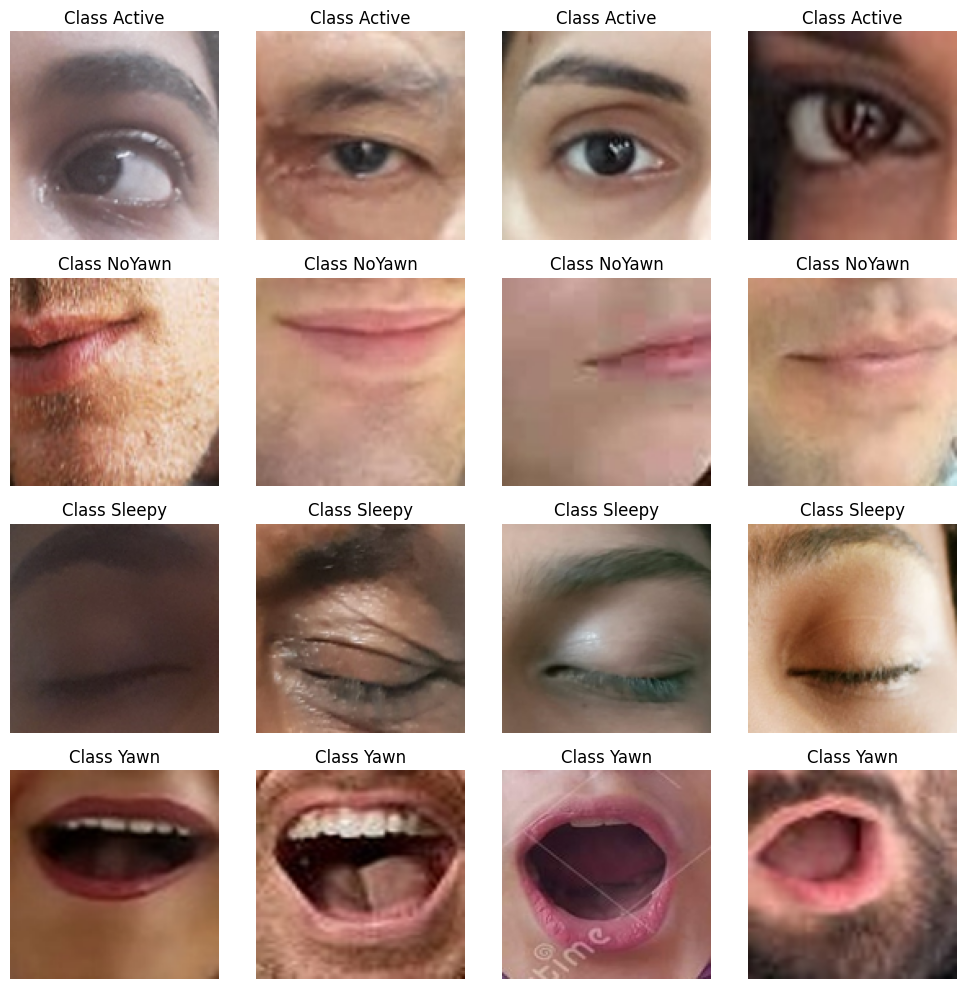

In [6]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Set your dataset path
dataset_path = 'dataset'

# Desired display size
img_size = (128, 128)

# Get class folders
class_folders = [os.path.join(dataset_path, d) for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# Plot
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

for i, class_folder in enumerate(class_folders):
    # Pick 4 random images
    images = random.sample(os.listdir(class_folder), 4)
    
    for j, img_name in enumerate(images):
        img_path = os.path.join(class_folder, img_name)
        img = Image.open(img_path).convert('RGB').resize(img_size)
        
        ax = axes[i, j]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Class {os.path.basename(class_folder)}")

plt.tight_layout()
plt.show()


In [2]:
import numpy as np
import cv2, os, tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

# Parameters
DATA_PATH = 'dataset/'
CLASSES = ['Active', 'Sleepy', 'Yawn', 'NoYawn']
NUM_CLASSES = len(CLASSES)

# Function to load dataset with variable image size
def load_dataset(img_size):
    images, labels = [], []
    for idx, c in enumerate(CLASSES):
        folder = os.path.join(DATA_PATH, c)
        for f in os.listdir(folder):
            img_path = os.path.join(folder, f)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(idx)
    return np.array(images), np.array(labels)

# k-Fold Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Model configurations
model_configs = {
    'cnn_model.h5': (64, 64),
    'mobilenetv2_model.h5': (96, 96),
    'inceptionv3_model.h5': (299, 299)
}

for model_path, img_size in model_configs.items():
    print(f"\n===== Evaluating {model_path} (Input size: {img_size}) =====")

    # Load dataset with correct input size for this model
    X, y = load_dataset(img_size)
    X = X.astype('float32') / 255.0
    y_cat = to_categorical(y, NUM_CLASSES)

    # Load the model
    model = load_model(model_path)

    # Metrics lists
    accs, precs, recs, f1s = [], [], [], []

    # Stratified K-Fold
    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y_cat[train_idx], y_cat[test_idx]

        preds = model.predict(X_test)
        y_pred = np.argmax(preds, axis=1)
        y_true = np.argmax(y_test, axis=1)

        accs.append(accuracy_score(y_true, y_pred))
        precs.append(precision_score(y_true, y_pred, average='macro'))
        recs.append(recall_score(y_true, y_pred, average='macro'))
        f1s.append(f1_score(y_true, y_pred, average='macro'))

    # Results
    print(f"Accuracy:  {np.mean(accs):.4f} ± {np.std(accs):.4f}")
    print(f"Precision: {np.mean(precs):.4f} ± {np.std(precs):.4f}")
    print(f"Recall:    {np.mean(recs):.4f} ± {np.std(recs):.4f}")
    print(f"F1-score:  {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")



===== Evaluating cnn_model.h5 (Input size: (64, 64)) =====


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
Accuracy:  0.9857 ± 0.0044
Precision: 0.9886 ± 0.0035
Recall:    0.9898 ± 0.0025
F1-score:  0.9892 ± 0.0030

===== Evaluating mobilenetv2_model.h5 (Input size: (96, 96)) =====


42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 245ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step
Accuracy:  0.9723 ± 0.0041
Precision: 0.9717 ± 0.0058
Recall:    0.9768 ± 0.0053
F1-score:  0.9740 ± 0.0056

===== Evaluating inceptionv3_model.h5 (Input size: (299, 299)) =====


42/42 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step
Accuracy:  0.9725 ± 0.0029
Precision: 0.9756 ± 0.0030
Recall:    0.9788 ± 0.0033
F1-score:  0.9772 ± 0.0030
